# Example to compute photon-ALP conversions in constant magnetic field and in the GMF

In [1]:
from gammaALPs import Source, ALP, ModuleList
from gammaALPs.base.transfer import w_pl_e9, EminGeV, EmaxGeV
import numpy as np
import matplotlib.pyplot as plt
from astropy import constants as c
from glob import glob


In [2]:
%matplotlib inline

In [81]:
m, g = 10., 2.
alp = ALP(m,g)

In [82]:
EGeV = np.logspace(0.,8.,1000)

In [83]:
pin = np.diag((1.,0.,0.))
punpol = np.diag((1.,1.,0.)) * 0.5
px_in = np.diag((1.,0.,0.))
py_in = np.diag((0.,1.,0.))
pa_in = np.diag((0.,0.,1.))

In [84]:
src = Source(z = 0., l = 0., b = 0., ra = None, dec = None)

In [85]:
m = ModuleList(alp, src, pin = pin, EGeV = EGeV, seed = 0)

In [86]:
m.add_propagation(environ = 'ICMCell', order = 0, 
                 B0 = 1.,
                 L0 = 10.,
                 nsim = 1,
                 n0 = 1e-3,
                 r_abell = 11.,
                 beta = 0., 
                 eta = 0.)

In [87]:
m.modules[0].psin = np.ones_like(m.modules[0].psin) * np.pi / 2.

In [88]:
px,py,pa = m.run(multiprocess=1)

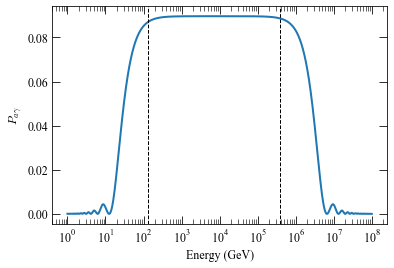

In [89]:
plt.semilogx(EGeV, pa[0], lw = 2)
plt.axvline(EminGeV(m_neV=m.alp.m, g11 = m.alp.g, BmuG=m.modules[0].B, n_cm3=m.modules[0].nel),
            lw = 1., ls = '--', color = 'k')
plt.axvline(EmaxGeV(g11=m.alp.g, BmuG=m.modules[0].B/2),
            lw = 1., ls = '--', color = 'k')
plt.xlabel("Energy (GeV)")
plt.ylabel("$P_{a\gamma}$")
plt.savefig("one_domain.pdf")

### Now do the GMF

In [70]:
EGeV = np.logspace(-1.,4.,101)
#src = Source(z = 0.017559, ra = '03h19m48.1s', dec = '+41d30m42s')
src = Source(z = 0.017559, l = 30., b = 0.)
m = ModuleList(alp, src, pin = pa_in, EGeV = EGeV, seed = 0)
m.add_propagation("GMF",0, model = 'jansson12', model_sum = 'ASS')

In [71]:
px,py,pa = m.run(multiprocess=1)

In [72]:
prx = m.modules[0].show_conv_prob_vs_r(pa_in, px_in)
pry = m.modules[0].show_conv_prob_vs_r(pa_in, py_in)
pra = m.modules[0].show_conv_prob_vs_r(pa_in, pa_in)

10.0


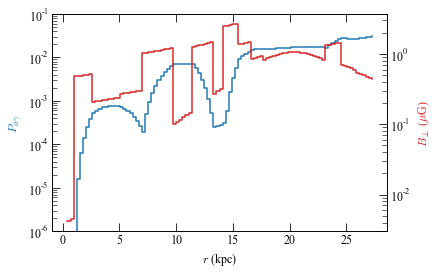

In [75]:
idx = 40
print EGeV[idx]
ax = plt.subplot(111)
ax.semilogy(m.modules[0]._r, (prx[:,idx] + pry[:,idx])[::-1], drawstyle = 'steps')
plt.ylabel("$P_{a\gamma}$", color = plt.cm.tab10(0.))
plt.xlabel("$r$ (kpc)")
ax.set_ylim(1e-6,1e-1)

ax2 = ax.twinx()
ax2.semilogy(m.modules[0]._r, m.modules[0].B[::-1], color = plt.cm.tab10(0.3), drawstyle = 'steps')
plt.ylabel("$B_{\perp}$ ($\mu$G)", color = plt.cm.tab10(0.3))
plt.savefig("pag_gmf_vs_r.pdf")

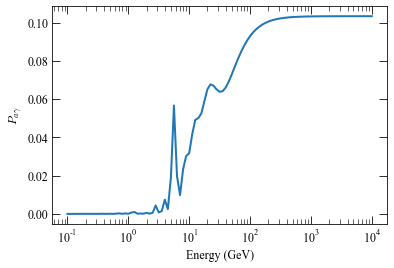

In [74]:
plt.semilogx(EGeV, px[0] + py[0], lw = 2)
plt.xlabel("Energy (GeV)")
plt.ylabel("$P_{a\gamma}$")
plt.savefig("pag_gmf.pdf")

### And the perseus cluster

In [48]:
EGeV = np.logspace(-1.,4.,101)
src = Source(z = 0.017559, ra = '03h19m48.1s', dec = '+41d30m42s')
m = ModuleList(alp, src, pin = punpol, EGeV = EGeV, seed = 0)
m.add_propagation("ICMGaussTurb", 
                  0, # position of module counted from the source. 
                  nsim = 10, # number of random B-field realizations
                  B0 = 10.,  # rms of B field
                  n0 = 39.,  # normalization of electron density
                  n2 = 4.05, # second normalization of electron density, see Churazov et al. 2003, Eq. 4
                  r_abell = 500., # extension of the cluster
                  r_core = 80.,   # electron density parameter, see Churazov et al. 2003, Eq. 4
                  r_core2 = 280., # electron density parameter, see Churazov et al. 2003, Eq. 4
                  beta = 1.2,  # electron density parameter, see Churazov et al. 2003, Eq. 4
                  beta2= 0.58, # electron density parameter, see Churazov et al. 2003, Eq. 4
                  eta = 0.5, # scaling of B-field with electron denstiy
                  kL = 0.18, # maximum turbulence scale in kpc^-1, taken from A2199 cool-core cluster, see Vacca et al. 2012 
                  kH = 9.,  # minimum turbulence scale, taken from A2199 cool-core cluster, see Vacca et al. 2012
                  q = -2.80, # turbulence spectral index, taken from A2199 cool-core cluster, see Vacca et al. 2012
                  thinning = 4 # thin out distance array. Can lead to different results!
                 )

In [49]:
px,py,pa = m.run(multiprocess=4)

In [50]:
print px.shape, m.modules[0]._r.shape

(10, 101) (1124,)


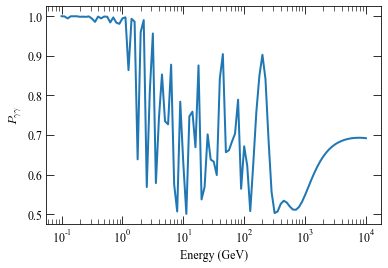

In [51]:
plt.semilogx(EGeV, px[0] + py[0], lw = 2)
plt.xlabel("Energy (GeV)")
plt.ylabel("$P_{\gamma\gamma}$")
plt.savefig("pgg_perseus_one_real.pdf")

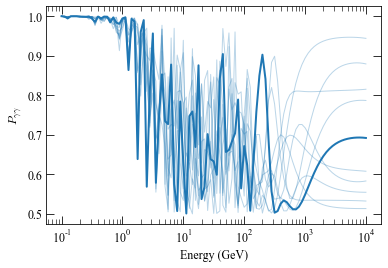

In [52]:
for i in range(px.shape[0]):
    plt.semilogx(EGeV, px[i] + py[i], lw = 1 if i else 2, alpha = 0.3 if i else 1., color = plt.cm.tab10(0.)
                )
plt.xlabel("Energy (GeV)")
plt.ylabel("$P_{\gamma\gamma}$")
plt.savefig("pgg_perseus_ten_real.pdf")

In [53]:
prx = m.modules[0].show_conv_prob_vs_r(punpol, pa_in)

In [55]:
prx.shape

(1124, 101)

10.0


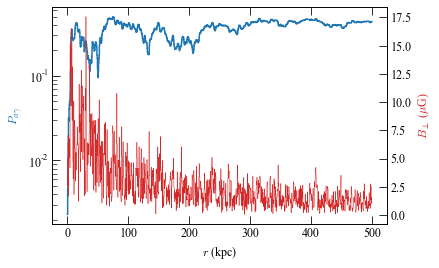

In [67]:
idx = 40
print EGeV[idx]
ax = plt.subplot(111)
ax.semilogy(m.modules[0].r, (prx[:,idx]), drawstyle = 'steps')
plt.ylabel("$P_{a\gamma}$",  color = plt.cm.tab10(0.))
plt.xlabel("$r$ (kpc)")

ax2 = ax.twinx()
ax2.plot(m.modules[0].r, m.modules[0].B, color =  plt.cm.tab10(0.3), drawstyle = 'steps', lw = 0.5)
plt.ylabel("$B_{\perp}$ ($\mu$G)", color =  plt.cm.tab10(0.3))
plt.savefig("pa_perseus_vs_r.pdf")